# Import required libraries

In [29]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Data Preprocessing

In [30]:
# Define batch size and image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#Mount Google Drive and set data paths
#from google.colab import drive
#drive.mount('/content/drive')

#data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
data_dir = 'chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Function to load paths and labels
def load_paths_labels(directory, set_name):
    filepaths, labels = [], []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                filepaths.append(os.path.join(folder_path, file))
                labels.append(folder)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels, 'set': set_name})

# Load data
train_df = load_paths_labels(train_dir, 'train')
val_df = load_paths_labels(val_dir, 'val')
test_df = load_paths_labels(test_dir, 'test')


# Data Generators

In [31]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Show sample from train data

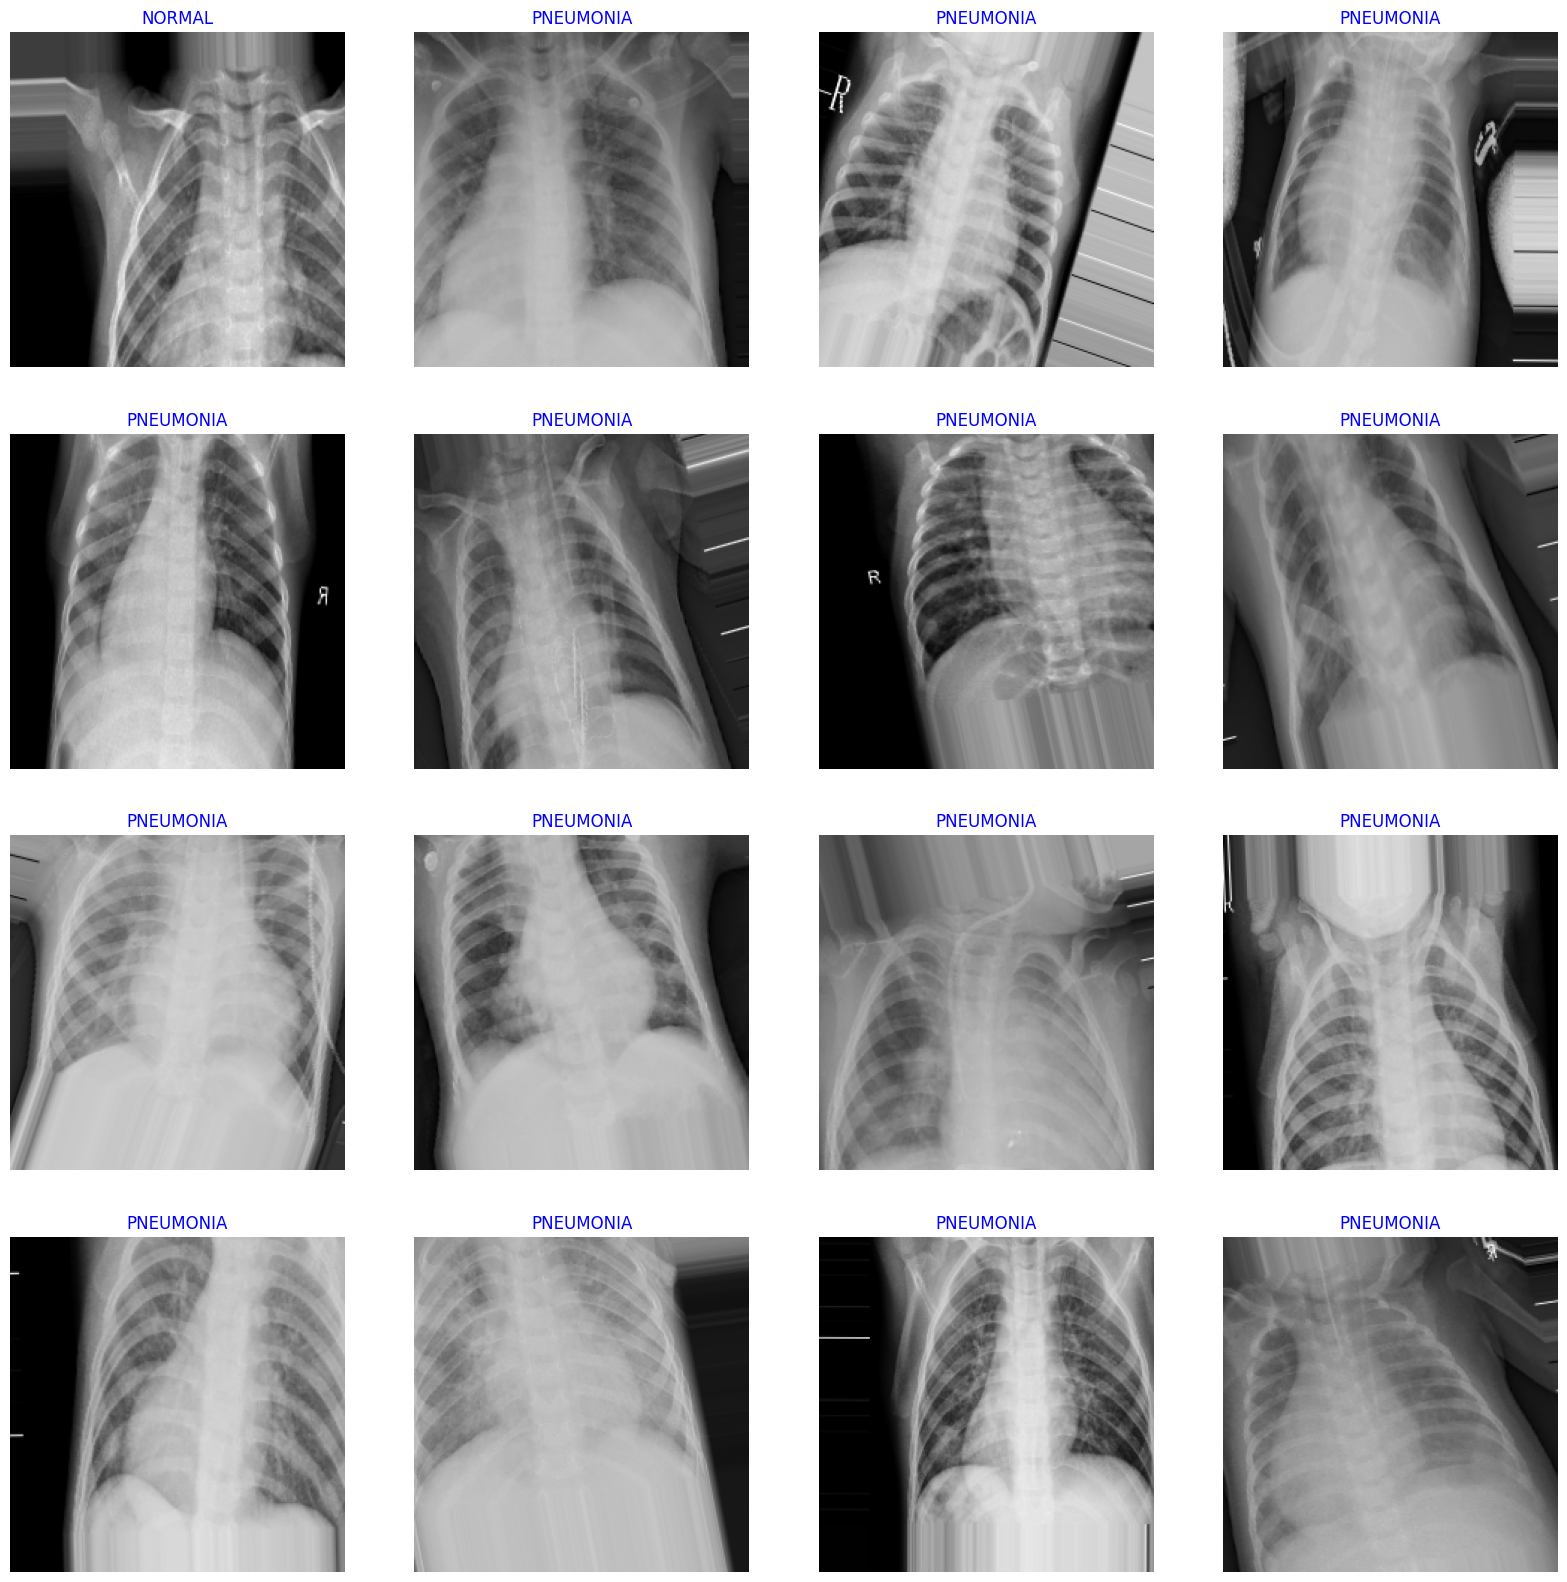

In [32]:
# Visualize a batch of images from the training generator
g_dict = train_gen.class_indices  # Defines dictionary {'class': index}
classes = list(g_dict.keys())     # Defines list of class names

# Retrieve a batch of images and labels from the generator
images, labels = next(train_gen)  # Get a batch of images and corresponding labels

# Plot the images
plt.figure(figsize=(20, 20))
for i in range(16):  # Display first 16 images
    plt.subplot(4, 4, i + 1)
    image = images[i]  # Image is already rescaled if rescale=1./255 is used in ImageDataGenerator
    plt.imshow(image)
    index = np.argmax(labels[i])  # Find the class index from the one-hot encoded labels
    class_name = classes[index]   # Map the index to the class name
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# Build the ResNet model

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers with L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(len(classes), activation='softmax', kernel_regularizer=l2(0.01))(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the model

In [36]:
start_time = time.time()
history = model.fit(
    train_gen,
    epochs=10,
    validation_data= valid_gen
)
training_time = time.time() - start_time
print(f"Training completed in: {training_time:.2f} seconds")

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 123s 376ms/step - accuracy: 0.7575 - loss: 0.5284 - val_accuracy: 0.5625 - val_loss: 0.8604
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 122s 375ms/step - accuracy: 0.7482 - loss: 0.5351 - val_accuracy: 0.5625 - val_loss: 0.8565
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 124s 379ms/step - accuracy: 0.7650 - loss: 0.5081 - val_accuracy: 0.5625 - val_loss: 0.9992
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 125s 382ms/step - accuracy: 0.7606 - loss: 0.5087 - val_accuracy: 0.5625 - val_loss: 0.9334
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 126s 385ms/step - accuracy: 0.7788 - loss: 0.4889 - val_accuracy: 0.5625 - val_loss: 0.7904
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 123s 377ms/step - accuracy: 0.7824 - loss: 0.4828 - val_accuracy: 0.5625 - val_loss: 0.8185
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 124s 380ms/step - accuracy: 0.7784 - loss: 0.4933 - val_accuracy: 0.6250 - val_loss: 0.6800
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 127s 389ms/step - accuracy: 0.7759 -

# Evaluate the model

C:\Users\William\PycharmProjects\pneumoniaImageClass\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.6532 - loss: 0.6800
Test Accuracy: 76.76%
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step
              precision    recall  f1-score   support

      NORMAL       0.73      0.60      0.66       234
   PNEUMONIA       0.78      0.87      0.82       390

    accuracy                           0.77       624
   macro avg       0.76      0.73      0.74       624
weighted avg       0.76      0.77      0.76       624



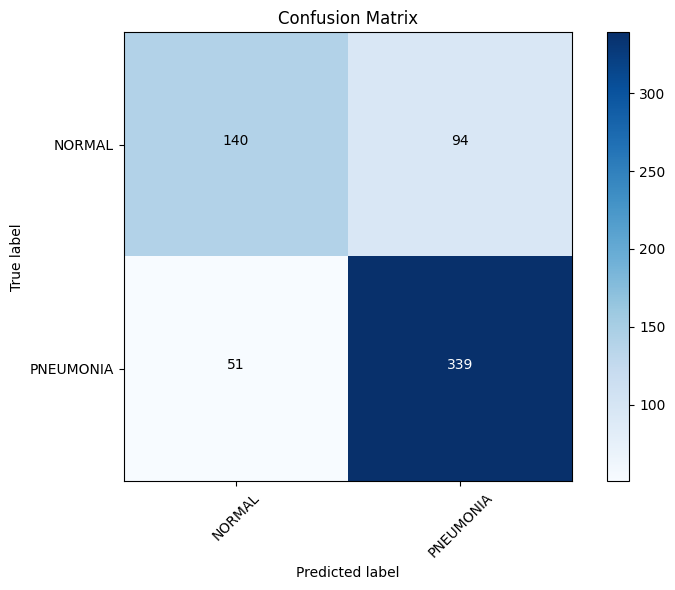

In [37]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Confusion matrix and classification report
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys())

print(report)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, list(test_gen.class_indices.keys()))
plt.show()

# Save the model

In [38]:
model.save('resnet50_pneumonia.h5')

# Display model performance

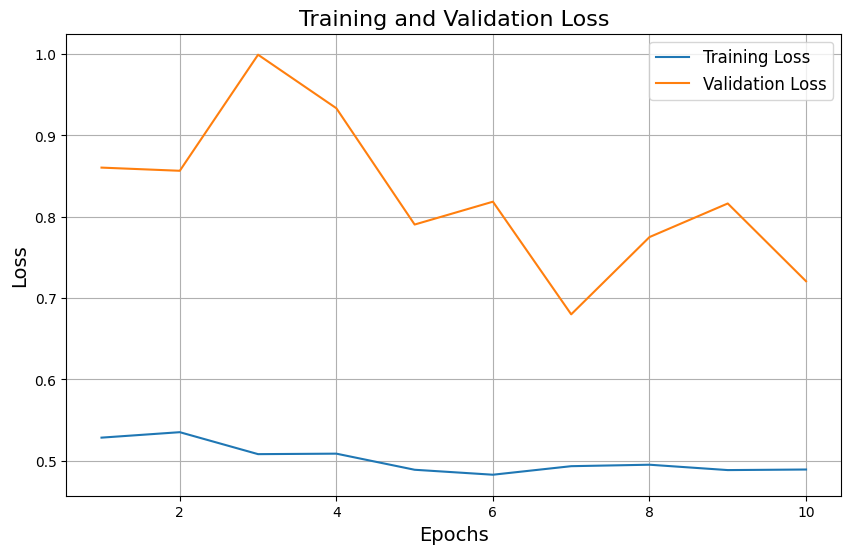

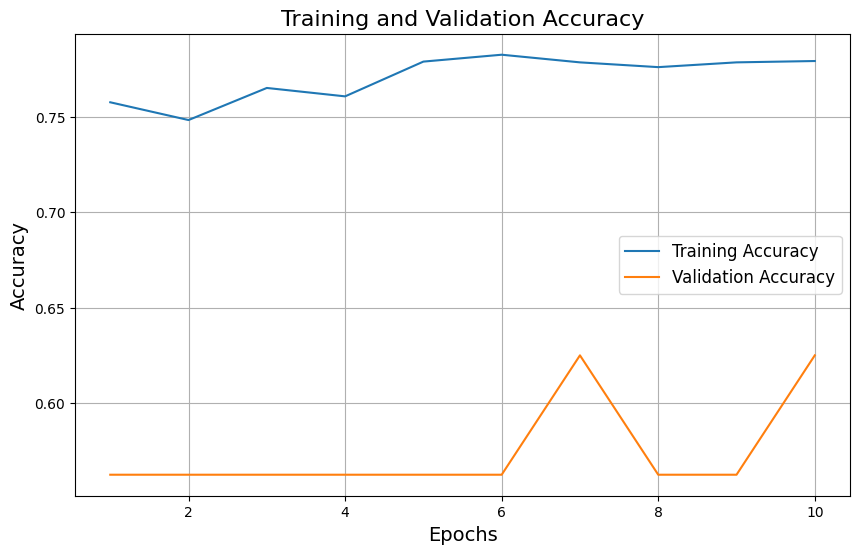

In [1]:
# Manually plotting from the logs
import matplotlib.pyplot as plt

# Extracted metrics from the training logs
epochs = list(range(1, 11))
train_loss = [0.5284, 0.5351, 0.5081, 0.5087, 0.4889, 0.4828, 0.4933, 0.4951, 0.4885, 0.4892]
val_loss = [0.8604, 0.8565, 0.9992, 0.9334, 0.7904, 0.8185, 0.6800, 0.7750, 0.8163, 0.7207]
train_accuracy = [0.7575, 0.7482, 0.7650, 0.7606, 0.7788, 0.7824, 0.7784, 0.7759, 0.7784, 0.7791]
val_accuracy = [0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.6250, 0.5625, 0.5625, 0.6250]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [40]:
from sklearn.metrics import classification_report

# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print(classification_report(test_gen.classes, y_pred_classes, target_names=classes))


              precision    recall  f1-score   support

      NORMAL       0.73      0.60      0.66       234
   PNEUMONIA       0.78      0.87      0.82       390

    accuracy                           0.77       624
   macro avg       0.76      0.73      0.74       624
weighted avg       0.76      0.77      0.76       624

